# Explore and visualise synthetic data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.dag_validation import run_dag_validation_tests, test_residual_independence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from models.train_random_forest import prepare_data, train_random_forest

# Load the data

In [2]:
data_path = '/mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet'

# Check if the data exists
try:
    data = pd.read_parquet(data_path)
    print(f"Data loaded from {data_path}")
except FileNotFoundError:
    print(f"File not found: {data_path}. Please generate the data first.")
    raise

# Show first few rows of data
data.head()

Data loaded from /mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet


,DTM,CHM,NDVI,LAI,Botrytis_Risk
0,76.161581,1.452191,0.495156,0.206789,0.0
1,76.445381,NaN,NaN,NaN,0.0
2,75.919406,NaN,NaN,NaN,0.0
3,75.809464,NaN,NaN,NaN,0.0
4,76.400783,NaN,NaN,NaN,0.0


# Reshape into 2D grid

In [3]:
field_width = 20  # meters
field_length = 200  # meters
resolution = 0.5  # meters per grid cell

grid_width = int(field_width / resolution)  # Number of grid cells in width
grid_length = int(field_length / resolution)  # Number of grid cells in length

# Reshape each column into a 2D grid
DTM = data['DTM'].values.reshape(grid_length, grid_width)
CHM = data['CHM'].values.reshape(grid_length, grid_width)
NDVI = data['NDVI'].values.reshape(grid_length, grid_width)
LAI = data['LAI'].values.reshape(grid_length, grid_width)
Botrytis_Risk = data['Botrytis_Risk'].values.reshape(grid_length, grid_width)

# Visualise 2D grids

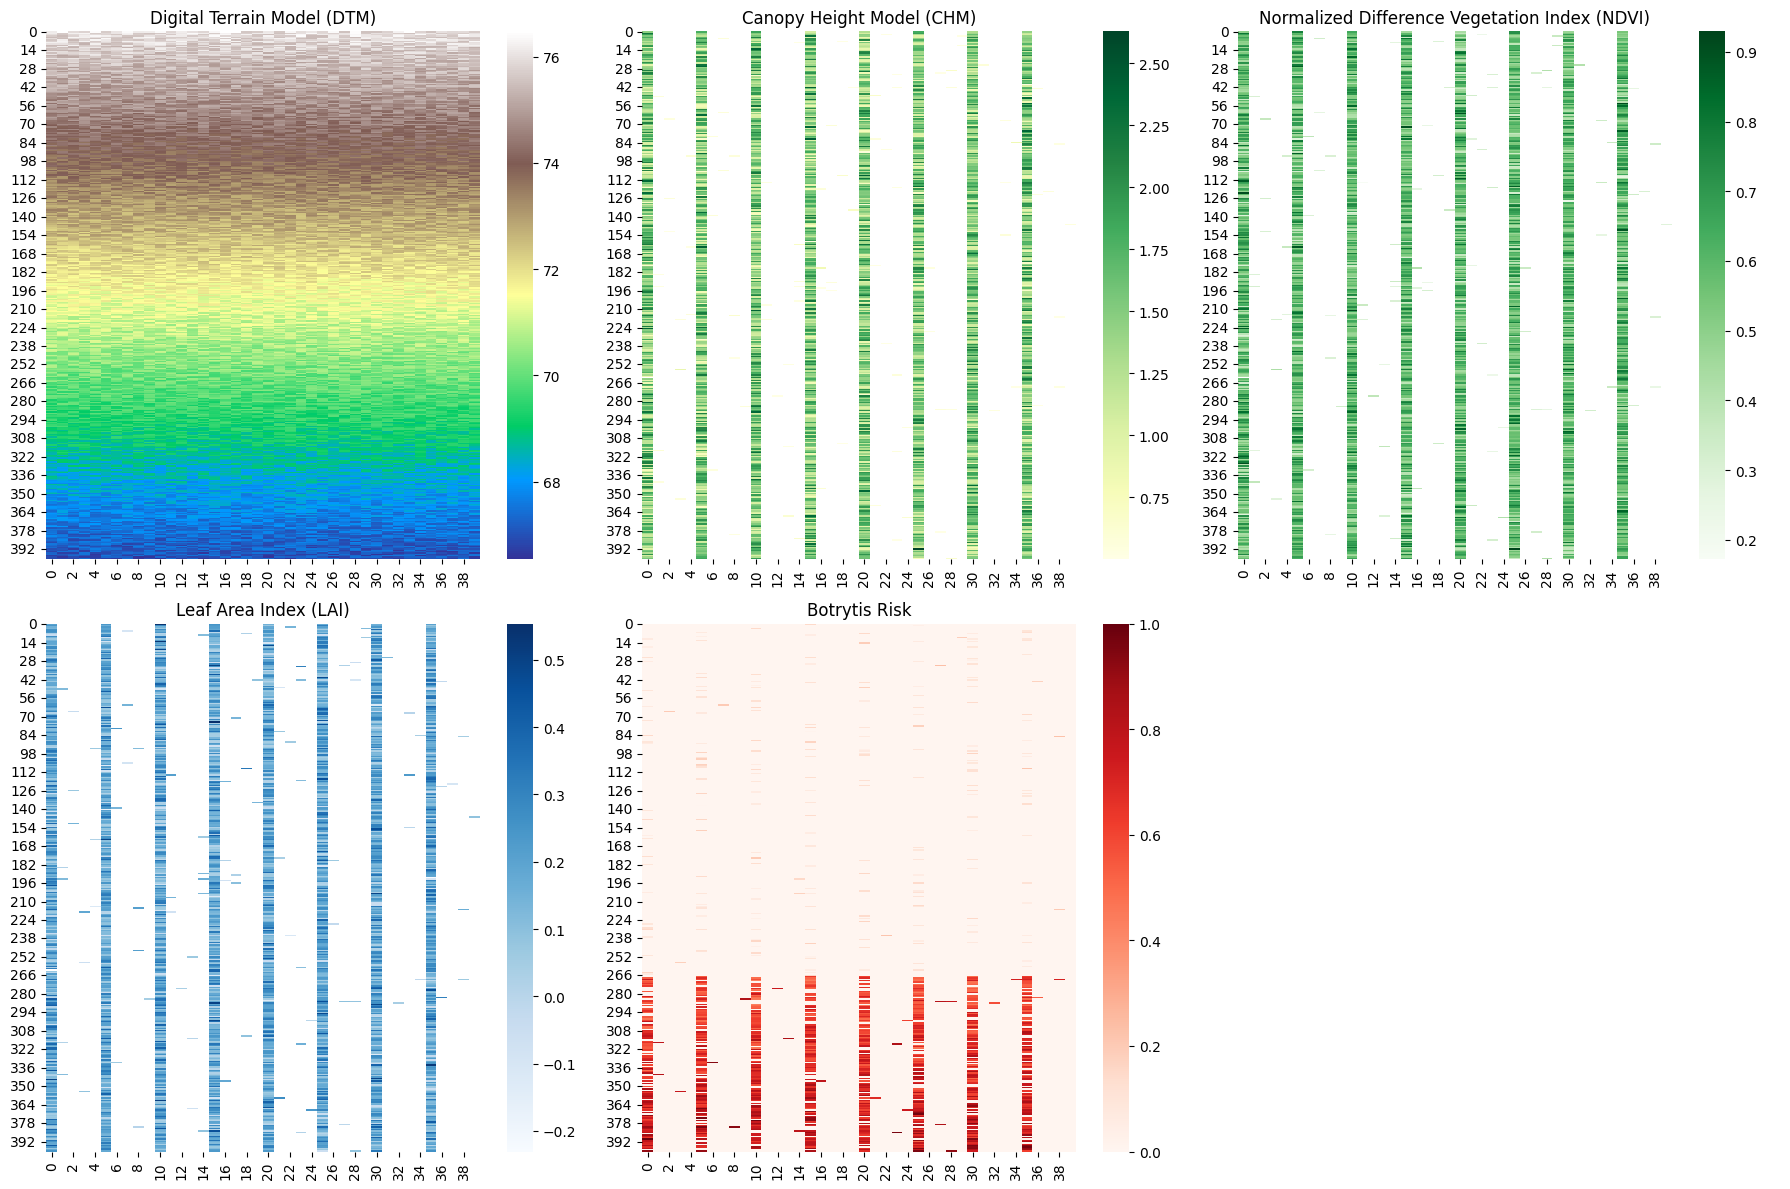

In [4]:
# Set up the figure size for better clarity
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot Digital Terrain Model (DTM)
sns.heatmap(DTM, ax=axes[0, 0], cmap='terrain', annot=False)
axes[0, 0].set_title('Digital Terrain Model (DTM)')

# Plot Canopy Height Model (CHM)
sns.heatmap(CHM, ax=axes[0, 1], cmap='YlGn', annot=False)
axes[0, 1].set_title('Canopy Height Model (CHM)')

# Plot Normalized Difference Vegetation Index (NDVI)
sns.heatmap(NDVI, ax=axes[0, 2], cmap='Greens', annot=False)
axes[0, 2].set_title('Normalized Difference Vegetation Index (NDVI)')

# Plot Leaf Area Index (LAI)
sns.heatmap(LAI, ax=axes[1, 0], cmap='Blues', annot=False)
axes[1, 0].set_title('Leaf Area Index (LAI)')

# Plot Botrytis Risk
sns.heatmap(Botrytis_Risk, ax=axes[1, 1], cmap='Reds', annot=False)
axes[1, 1].set_title('Botrytis Risk')

# Leave the last plot empty for spacing
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Dependency Check with Residual Independence Tests

## Test 1: DTM and Botrytis Risk conditional on CHM and LAI


Testing DTM and Botrytis Risk conditional on CHM and LAI:


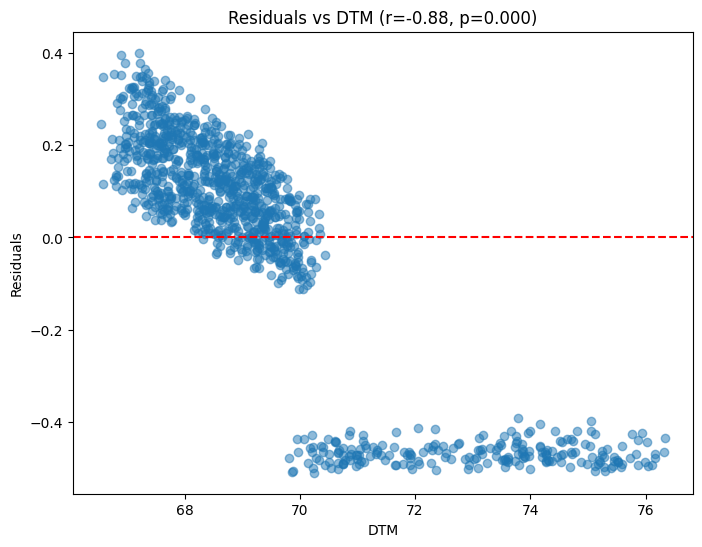

Result: {'correlation_coefficient': np.float64(-0.8777581096241653), 'p_value': np.float64(0.0)}


In [5]:
# Set a threshold for Botrytis Risk
risk_threshold = 0

# Filter the data to include only rows where Botrytis Risk is above the threshold
filtered_data = data[data['Botrytis_Risk'] > risk_threshold]

# Prepare the features and target for the test
X = filtered_data[['CHM', 'LAI']]
y = filtered_data['Botrytis_Risk']
conditioning_var = filtered_data['DTM']

# Run the test for conditional independence
print("\nTesting DTM and Botrytis Risk conditional on CHM and LAI:")
test_result = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result}")


Testing CHM and NDVI direct dependence:


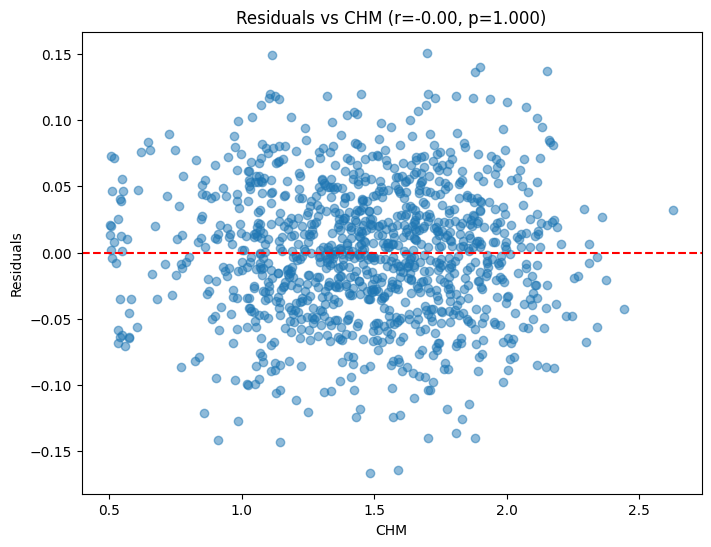

Result: {'correlation_coefficient': np.float64(-1.0755285551056204e-15), 'p_value': np.float64(0.9999999999999708)}


In [6]:
X = filtered_data[['CHM']]
y = filtered_data['NDVI']
conditioning_var = filtered_data['CHM']
print("\nTesting CHM and NDVI direct dependence:")
test_result_2 = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result_2}")


Testing LAI and NDVI conditional on Botrytis Risk:


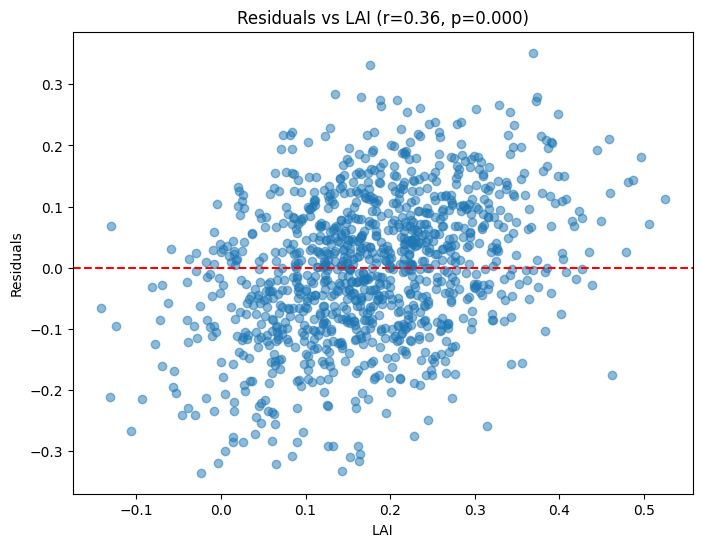

Result: {'correlation_coefficient': np.float64(0.3645025805097968), 'p_value': np.float64(1.1937455740583074e-35)}


In [7]:
# Test 3: LAI and NDVI conditional on Botrytis Risk
X = filtered_data[['Botrytis_Risk']]
y = filtered_data['NDVI']
conditioning_var = filtered_data['LAI']
print("\nTesting LAI and NDVI conditional on Botrytis Risk:")
test_result_3 = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result_3}")


Testing DTM and NDVI conditional on CHM:


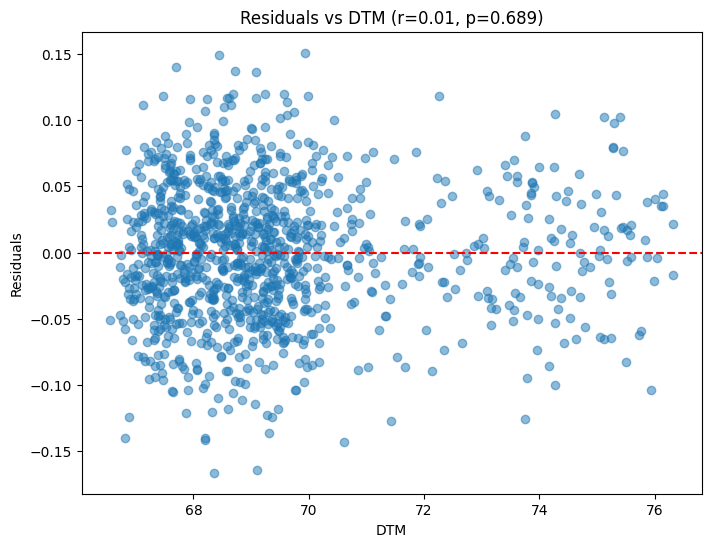

Result: {'correlation_coefficient': np.float64(0.012131268053301534), 'p_value': np.float64(0.6888335762495046)}


In [8]:
X = filtered_data[['CHM']]
y = filtered_data['NDVI']
conditioning_var = filtered_data['DTM']
print("\nTesting DTM and NDVI conditional on CHM:")
test_result_4 = test_residual_independence(X, y, conditioning_var)
print(f"Result: {test_result_4}")

# Train Classifier

## Load Data

Accuracy: 0.8996960486322189
Classification Report:
              precision    recall  f1-score     support
0              0.980088  0.886000  0.930672  500.000000
1              0.723301  0.943038  0.818681  158.000000
accuracy       0.899696  0.899696  0.899696    0.899696
macro avg      0.851695  0.914519  0.874677  658.000000
weighted avg   0.918428  0.899696  0.903781  658.000000
Feature Importances:
  feature  importance
0     DTM        0.56
1     CHM        0.18
3     LAI        0.18
2    NDVI        0.08


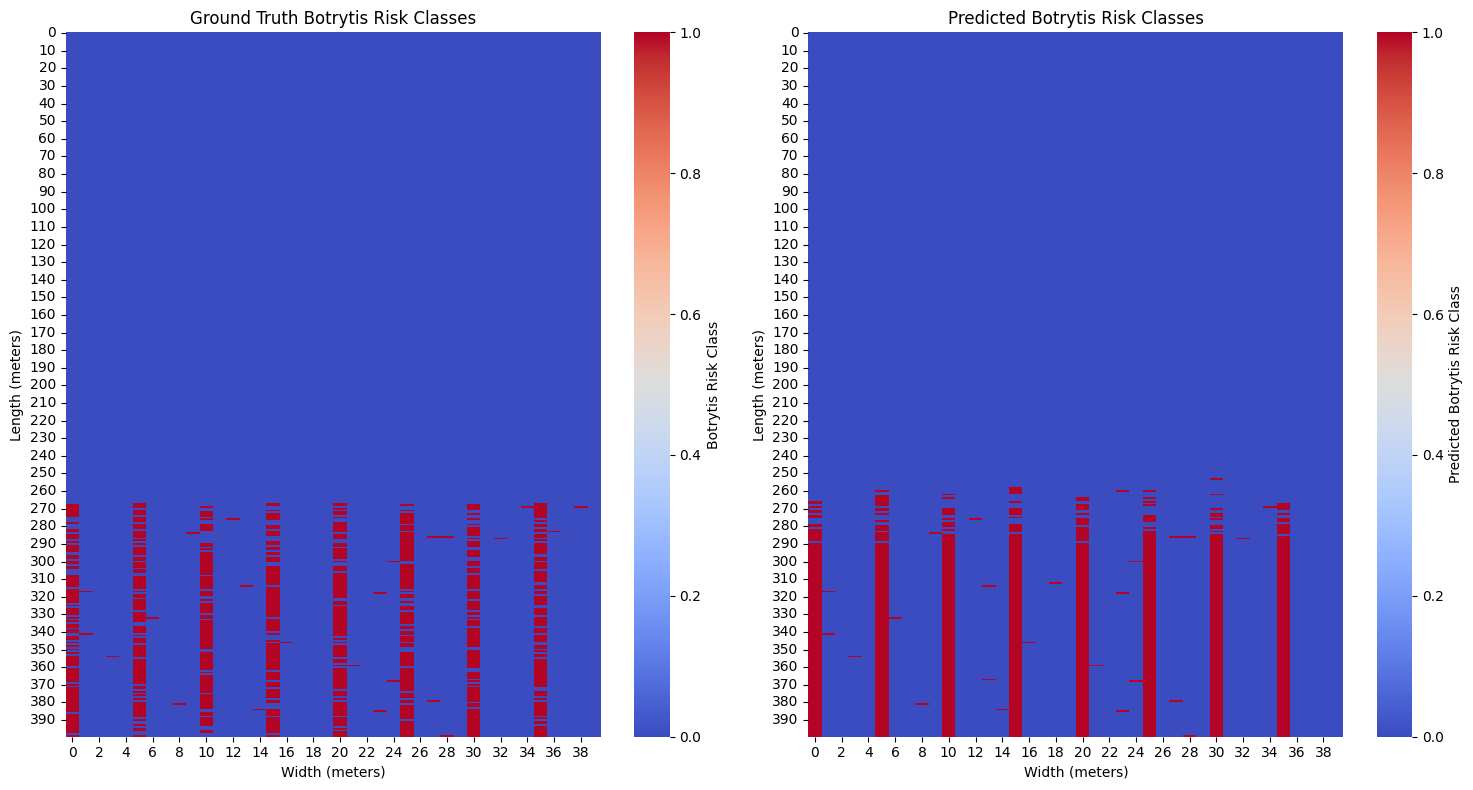

In [9]:
# Load and prepare data
data_path = '/mnt/RAID/projects/PCS956-Project/data/synthetic_vineyard_data.parquet'
data = pd.read_parquet(data_path)

# Prepare features, target variable, NaN mask, and full data
X, y, nan_mask, full_data = prepare_data(data, risk_threshold=0.5)

# Train Random Forest model
metrics, feature_importance_df, rf_model = train_random_forest(X, y, max_depth=1)

# Display metrics and feature importances
print("Accuracy:", metrics['accuracy'])
print("Classification Report:")
print(pd.DataFrame(metrics['classification_report']).transpose())
print("Feature Importances:")
print(feature_importance_df)

# Predict on the prepared data
y_pred = rf_model.predict(X)

# Reshape predictions and ground truth to the original 2D grid dimensions for visualization
field_width = 20  # meters
field_length = 200  # meters
resolution = 0.5  # meters per grid cell

grid_width = int(field_width / resolution)
grid_length = int(field_length / resolution)

# Create binary classification grid based on the threshold
Botrytis_Risk_Class = (data['Botrytis_Risk'] > 0.5).astype(int)  # Ground truth for Botrytis Risk Class
y_pred_full = np.full(Botrytis_Risk_Class.shape, np.nan)  # Placeholder for predictions

# Map the predictions back to the full grid, excluding NaN locations
y_pred_full[~nan_mask] = y_pred

# Reshape ground truth and predictions, applying NaN mask
Botrytis_Risk_Class_grid = Botrytis_Risk_Class.values.reshape(grid_length, grid_width)
Predicted_Class_grid = y_pred_full.reshape(grid_length, grid_width)
Predicted_Class_grid = np.nan_to_num(Predicted_Class_grid)

# Plot the ground truth and predicted classifications side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the ground truth
sns.heatmap(Botrytis_Risk_Class_grid, ax=axes[0], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Botrytis Risk Class'})
axes[0].set_title('Ground Truth Botrytis Risk Classes')
axes[0].set_xlabel('Width (meters)')
axes[0].set_ylabel('Length (meters)')

# Plot the predicted classifications
sns.heatmap(Predicted_Class_grid, ax=axes[1], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Predicted Botrytis Risk Class'})
axes[1].set_title('Predicted Botrytis Risk Classes')
axes[1].set_xlabel('Width (meters)')
axes[1].set_ylabel('Length (meters)')

plt.tight_layout()
plt.show()

# KDE

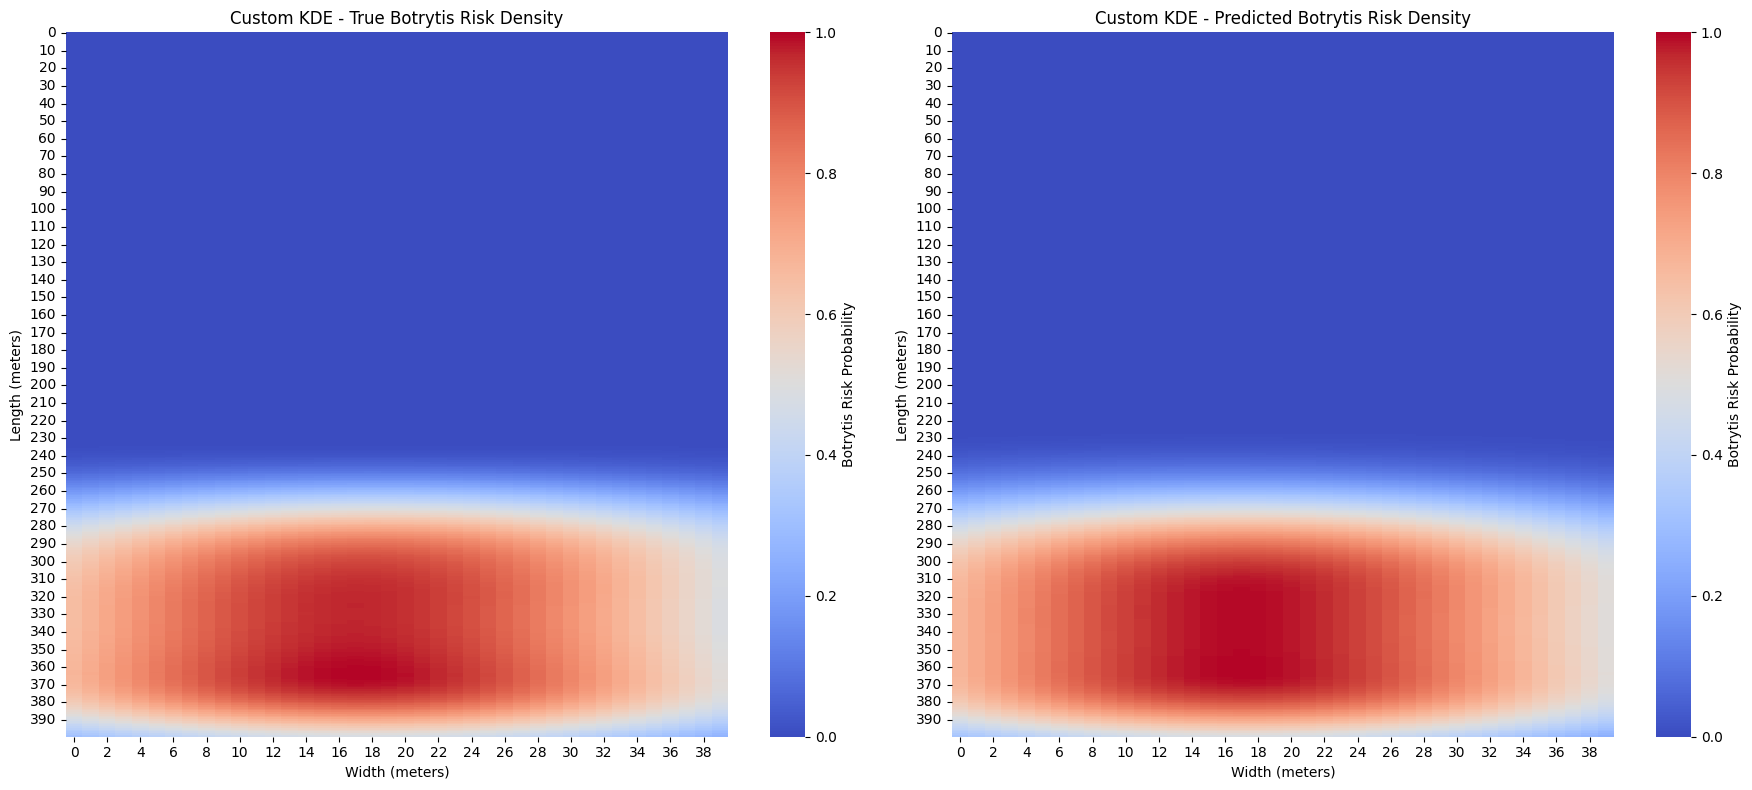

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree

# Define the biweight (quartic) kernel function
def biweight_kernel(distances, bandwidth):
    u = distances / bandwidth
    weights = np.where(u < 1, (15 / 16) * (1 - u**2)**2, 0)
    return weights

# 2D KDE using a custom kernel
def custom_kde2D(x, y, bandwidth, grid_width, grid_length, resolution, kernel_func):
    """Perform 2D KDE using a custom kernel over grid dimensions and resolution."""
    # Define grid for the KDE
    x_grid = np.linspace(0, field_width, grid_width)
    y_grid = np.linspace(0, field_length, grid_length)
    xx, yy = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Prepare sample points for KDE
    sample_points = np.vstack([x, y]).T
    
    # Build KD-Tree for sample points
    tree = cKDTree(sample_points)
    
    # Query distances to all sample points within bandwidth for each grid point
    distances, _ = tree.query(grid_points, k=len(sample_points), distance_upper_bound=bandwidth)
    
    # Apply custom kernel to distances
    density_values = kernel_func(distances, bandwidth).sum(axis=1)
    
    # Reshape density values to grid and normalize for visualization
    density_grid = density_values.reshape(grid_length, grid_width)
    density_normalized = (density_grid - density_grid.min()) / (density_grid.max() - density_grid.min())
    
    return density_normalized

# Example parameters for grid and data (using actual Botrytis data for true/predicted KDE)
field_width, field_length, resolution = 20, 200, 0.5
grid_width = int(field_width / resolution)
grid_length = int(field_length / resolution)
bandwidth = 19.68

# Assume Botrytis_Risk_Class_grid and Predicted_Class_grid are defined binary grids (0/1)
# Extract presence points from these grids for KDE

# For the true presence points
y_indices_true, x_indices_true = np.where(Botrytis_Risk_Class_grid == 1)
presence_points_true = np.column_stack((x_indices_true * resolution, y_indices_true * resolution))

# For the predicted presence points
y_indices_pred, x_indices_pred = np.where(Predicted_Class_grid == 1)
presence_points_pred = np.column_stack((x_indices_pred * resolution, y_indices_pred * resolution))

# Run custom KDE with biweight kernel on true presence points
density_true_custom = custom_kde2D(
    presence_points_true[:, 0], 
    presence_points_true[:, 1], 
    bandwidth, grid_width, grid_length, resolution, biweight_kernel
)

# Run custom KDE with biweight kernel on predicted presence points
density_pred_custom = custom_kde2D(
    presence_points_pred[:, 0], 
    presence_points_pred[:, 1], 
    bandwidth, grid_width, grid_length, resolution, biweight_kernel
)

# Plotting KDE density heatmaps for true and predicted with custom kernel
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# KDE for True Presence Points with Custom Kernel
sns.heatmap(density_true_custom, ax=axes[0], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Botrytis Risk Probability'})
axes[0].set_title("Custom KDE - True Botrytis Risk Density")
axes[0].set_xlabel("Width (meters)")
axes[0].set_ylabel("Length (meters)")

# KDE for Predicted Presence Points with Custom Kernel
sns.heatmap(density_pred_custom, ax=axes[1], cmap='coolwarm', cbar=True, cbar_kws={'label': 'Botrytis Risk Probability'})
axes[1].set_title("Custom KDE - Predicted Botrytis Risk Density")
axes[1].set_xlabel("Width (meters)")
axes[1].set_ylabel("Length (meters)")

plt.tight_layout()
plt.show()
